In [1]:
!pip install sagemaker==1.72.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [15]:
%matplotlib inline
import os
import ast
import json
import numpy as np
import pandas as pd
import source
import math

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import Audio
sound_file = './sound/beep.wav'

import warnings
warnings.filterwarnings('ignore')

session = sagemaker.Session()
role = get_execution_role()

<h2> Data Processing </h2>

ROI is calculated using next price because we are trying to predict future ROI using the data from current time period.
Referred to https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb & https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

In [246]:
DATA_DIR = './data'

In [247]:
data = pd.read_csv(os.path.join(DATA_DIR, 'crypto-historical-data.csv'), 
                   parse_dates=['time'], 
                   index_col=0, 
                   keep_default_na=False,
                   header=0,
                   names=['market_cap', 'name', 'price', 'sym', 'time', 'volume'])

data.sort_values(by=['sym', 'time'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [248]:
data['rank'] = data.groupby("time")["market_cap"] \
                    .rank("dense", ascending=False) \
                    .astype(int)

data['market_share'] = data.groupby('time')["market_cap"] \
                    .apply(lambda x: x/float(x.sum()))

data['age'] = data.groupby(['sym'])["time"] \
                    .apply(lambda x: x - min(x)) \
                    .dt.days + 1

previous_price = data.groupby(['sym'])['price'].shift(-1)
data['roi'] = data['price']/previous_price - 1

In [249]:
data[data['sym'] == 'ETH'].head(10)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
224231,167911000.0,Ethereum,0.753325,ETH,2015-08-08,674188.0,4,0.034732,1,0.073270
224232,42637600.0,Ethereum,0.701897,ETH,2015-08-09,532170.0,4,0.009641,2,-0.009247
224233,43130000.0,Ethereum,0.708448,ETH,2015-08-10,405283.0,4,0.009581,3,-0.337899
224234,42796500.0,Ethereum,1.070000,ETH,2015-08-11,1463100.0,4,0.009541,4,-0.122951
224235,64018400.0,Ethereum,1.220000,ETH,2015-08-12,2150620.0,4,0.013904,5,-0.333333
224236,73935400.0,Ethereum,1.830000,ETH,2015-08-13,4068680.0,4,0.016312,6,0.000000
224237,109594000.0,Ethereum,1.830000,ETH,2015-08-14,4637030.0,4,0.024201,7,0.082840
224238,109160000.0,Ethereum,1.690000,ETH,2015-08-15,2554360.0,4,0.023926,8,0.076433
224239,102028000.0,Ethereum,1.570000,ETH,2015-08-16,3550790.0,4,0.022676,9,0.308333
224240,95819700.0,Ethereum,1.200000,ETH,2015-08-17,1942830.0,4,0.021582,10,0.100917


<h2> Data Selection </h2>

In [250]:
TRAIN_START = min(data['time'])
VAL_START = pd.Timestamp('2016-04-25')
TEST_START = pd.Timestamp('2017-04-25')
END_TRAIN = TEST_START - pd.Timedelta(1, 'D')

In [251]:
TRAIN_START

Timestamp('2013-04-28 00:00:00')

In [252]:
END_TRAIN

Timestamp('2017-04-24 00:00:00')

In [213]:
train_window = data.query('time < @VAL_START')
mean_daily = train_window.groupby(['sym']).mean()
SYMBOLS = mean_daily.query("market_cap > 1000000 & volume > 10000").index.unique()

In [214]:
filtered = data.query('sym in @SYMBOLS')
# filtered = filtered.query('sym == "ETH"')

In [215]:
filtered.sort_values(by=['sym', 'time'], inplace=True)
filtered.reset_index(drop=True, inplace=True)

In [216]:
data = None

<h2> Feature Engineering </h2>

In [217]:
feat = filtered.copy()

In [218]:
W = 7
TARGET = 'price'

In [219]:
properties = ['market_cap', 'price', 'volume', 'rank', 'market_share', 'age', 'roi']
# properties = ['market_cap', 'price', 'volume', 'age', 'roi']
feat_columns = []

for p in properties:
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        feat[col_name] = feat.groupby(['sym'])[p].shift(w)
        feat_columns.append(col_name)
    
    feat[p + '_mean'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(W, min_periods=1).mean())
    feat[p + '_std'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(W, min_periods=1).std())

feat.dropna(inplace=True)

In [220]:
feat.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
7,822920.0,Synereo,0.004448,AMP,2015-12-25,2.0,37,0.000111,10,-0.020264,...,2.690371,0.001349,-0.066682,0.011787,-0.063481,-0.110180,0.259629,-0.210646,-0.025460,0.146058
8,834549.0,Synereo,0.004540,AMP,2015-12-26,18.0,38,0.000112,11,-0.013043,...,2.992053,-0.020264,0.001349,-0.066682,0.011787,-0.063481,-0.110180,0.259629,0.001737,0.121486
9,837453.0,Synereo,0.004600,AMP,2015-12-27,26.0,36,0.000123,12,-0.002386,...,3.132016,-0.013043,-0.020264,0.001349,-0.066682,0.011787,-0.063481,-0.110180,-0.037216,0.044049
10,851183.0,Synereo,0.004611,AMP,2015-12-28,23.0,37,0.000123,13,0.064896,...,3.132016,-0.002386,-0.013043,-0.020264,0.001349,-0.066682,0.011787,-0.063481,-0.021817,0.031283
11,864300.0,Synereo,0.004330,AMP,2015-12-29,1.0,37,0.000125,14,-0.296735,...,2.992053,0.064896,-0.002386,-0.013043,-0.020264,0.001349,-0.066682,0.011787,-0.003478,0.039371


<h2> Data Split </h2>

1. scale train based on symbol

In [221]:
train = feat.query("time < @VAL_START")
val = feat.query("time >= @VAL_START & time < @TEST_START")
trainval = feat.query("time <= @TEST_START")
test = feat.query("time >= @TEST_START")

In [222]:
feat = None

In [223]:
cols_to_scale = feat_columns + [TARGET]

In [224]:
# scaler_dict = {}
# train_scaled = pd.DataFrame()

# for sym in SYMBOLS:
#     scaler_train = StandardScaler()
#     sym_train = train.query("sym == @sym")
#     sym_train[cols_to_scale] = scaler_train.fit_transform(sym_train[cols_to_scale])
    
#     train_scaled = pd.concat([train_scaled, sym_train], axis=0)
    
#     scaler_dict[sym] = scaler_train

# train_scaled.sort_values(by=['sym', 'time'], inplace=True)
# train_scaled.reset_index(drop=True, inplace=True)

In [225]:
def scale_col(df, base, col):
    mean = df[base + '_mean']
    std = df[base + '_std']
    std = np.where(std == 0, 0.001, std)
    return (df[col] - mean)/std

In [226]:
trainval_scaled = trainval.copy()
for p in properties:
    trainval_scaled[p] = scale_col(trainval_scaled, p, p)
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        trainval_scaled[col_name] = scale_col(trainval_scaled, p, col_name)

In [227]:
val_scaled = val.copy()
for p in properties:
    val_scaled[p] = scale_col(val_scaled, p, p)
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        val_scaled[col_name] = scale_col(val_scaled, p, col_name)

In [228]:
test_scaled = test.copy()
for p in properties:
    test_scaled[p] = scale_col(test_scaled, p, p)
    
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        test_scaled[col_name] = scale_col(test_scaled, p, col_name)

In [229]:
test_scaled.describe()

,market_cap,price,volume,rank,market_share,age,roi,market_cap_lag_1,market_cap_lag_2,market_cap_lag_3,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
count,13007.000000,1.300700e+04,1.300700e+04,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,...,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000,13007.000000
mean,0.270739,1.679970e-01,6.092668e+03,66.622537,-0.129323,1.851912,-0.000730,0.048943,0.017197,-0.002063,...,2.163436,-0.008858,-0.004928,-0.004355,-0.004699,0.001808,0.011210,0.009822,0.006045,0.109214
std,8.585780,2.021850e+00,2.851716e+05,3129.445036,2.237954,0.059661,1.567497,1.093715,0.865874,0.774281,...,0.134888,0.922142,0.922319,0.926532,0.925193,0.927509,0.929121,0.927949,0.058275,0.131429
min,-18.753049,-1.115415e+01,-7.922857e+05,-89426.540288,-12.715254,0.878310,-17.418439,-2.246479,-2.192674,-2.202570,...,2.160247,-2.257281,-2.252014,-2.255698,-2.232111,-2.217908,-2.225340,-2.212337,-0.293394,0.002964
25%,-0.980566,-9.616326e-01,-8.722231e-01,-0.377964,-1.268290,1.851640,-0.719682,-0.846917,-0.664355,-0.548209,...,2.160247,-0.649406,-0.662666,-0.677918,-0.678834,-0.672873,-0.665673,-0.646577,-0.019002,0.055748
50%,0.013138,-9.578925e-08,-3.563138e-01,0.347013,-0.408264,1.851640,-0.030504,0.007387,-0.014068,-0.030740,...,2.160247,-0.026439,-0.026806,-0.011559,-0.007699,-0.005522,-0.010338,-0.017433,0.002450,0.084558
75%,1.112692,1.081497e+00,6.155262e-01,1.315335,0.645527,1.851640,0.685076,0.948235,0.691611,0.519800,...,2.160247,0.626531,0.622692,0.655993,0.659165,0.674698,0.676594,0.650309,0.025285,0.127210
max,946.026299,4.205749e+01,2.834043e+07,99555.191430,90.278672,8.332381,32.125677,2.267779,2.258916,2.252378,...,9.416298,2.262815,2.259329,2.259030,2.258160,2.253826,2.253327,2.249147,1.325704,3.442886


In [230]:
test.query('sym == "ETH"')[[col for col in test.columns if 'price' in col]]

,price,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_mean,price_std
13653,49.89,50.03,48.49,48.55,48.22,49.67,48.31,50.71,49.140000,0.986898
13654,52.72,49.89,50.03,48.49,48.55,48.22,49.67,48.31,49.022857,0.800556
13655,62.17,52.72,49.89,50.03,48.49,48.55,48.22,49.67,49.652857,1.539900
13656,70.16,62.17,52.72,49.89,50.03,48.49,48.55,48.22,51.438571,4.976359
13657,68.38,70.16,62.17,52.72,49.89,50.03,48.49,48.55,54.572857,8.366116
...,...,...,...,...,...,...,...,...,...,...
14000,385.31,370.29,383.23,380.54,416.89,386.43,379.61,396.46,387.635714,15.111697
14001,400.51,385.31,370.29,383.23,380.54,416.89,386.43,379.61,386.042857,14.605712
14002,398.53,400.51,385.31,370.29,383.23,380.54,416.89,386.43,389.028571,15.195811
14003,414.24,398.53,400.51,385.31,370.29,383.23,380.54,416.89,390.757143,15.535363


In [231]:
test_scaled.query('sym == "ETH"')[[col for col in test_scaled.columns if 'price' in col]]

,price,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_mean,price_std
13653,0.759957,0.901816,-0.658630,-0.597833,-0.932214,0.537037,-0.841019,1.590844,49.140000,0.986898
13654,4.618217,1.083175,1.258054,-0.665609,-0.590661,-1.002874,0.808366,-0.890452,49.022857,0.800556
13655,8.128545,1.991781,0.153999,0.244914,-0.755151,-0.716188,-0.930487,0.011132,49.652857,1.539900
13656,3.762074,2.156482,0.257503,-0.311186,-0.283053,-0.592516,-0.580459,-0.646772,51.438571,4.976359
13657,1.650365,1.863128,0.908085,-0.221472,-0.559741,-0.543007,-0.727083,-0.719911,54.572857,8.366116
...,...,...,...,...,...,...,...,...,...,...
14000,-0.153902,-1.147834,-0.291543,-0.469551,1.935870,-0.079787,-0.531093,0.583937,387.635714,15.111697
14001,0.990513,-0.050176,-1.078541,-0.192586,-0.376761,2.111992,0.026506,-0.440434,386.042857,14.605712
14002,0.625266,0.755565,-0.244710,-1.233141,-0.381590,-0.558613,1.833494,-0.171006,389.028571,15.195811
14003,1.511574,0.500333,0.627784,-0.350629,-1.317455,-0.484517,-0.657670,1.682153,390.757143,15.535363


In [232]:
trainval_scaled.query('sym == "ETH"')

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
13034,0.675510,Ethereum,1.065853,ETH,2015-08-15,0.325754,0.0,0.745782,1.85164,0.942114,...,2.160247,0.977851,0.515793,-1.343438,-0.169989,-1.368904,0.464216,0.924471,-0.092474,0.179286
13035,1.094176,Ethereum,0.557823,ETH,2015-08-16,0.789225,0.0,1.132440,1.85164,2.226967,...,2.160247,0.937029,0.972668,0.511872,-1.342285,-0.172038,-1.367682,0.460436,-0.092022,0.179776
13036,0.611008,Ethereum,-0.506540,ETH,2015-08-17,-0.498707,0.0,0.681093,1.85164,0.626460,...,2.160247,1.506968,0.522521,0.549720,0.198052,-1.216993,-0.323891,-1.236376,-0.046654,0.235564
13037,0.109567,Ethereum,-1.244578,ETH,2015-08-18,-1.198626,0.0,0.184824,1.85164,-0.751049,...,2.160247,0.422321,1.454282,0.300504,0.332381,-0.079776,-1.738217,-0.691496,0.016034,0.200992
13038,-0.407962,Ethereum,-0.730619,ETH,2015-08-19,-1.205497,0.0,0.370173,1.85164,-0.747518,...,2.160247,-0.737313,0.427795,1.452489,0.306835,0.338488,-0.070766,-1.717529,0.014324,0.202417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13649,0.720030,Ethereum,-0.668560,ETH,2017-04-21,-1.010141,0.0,-0.539577,1.85164,-0.152828,...,2.160247,0.891740,-0.736021,1.447310,-1.306772,0.286127,0.260742,-0.843125,-0.001403,0.035295
13650,-0.603094,Ethereum,-0.495874,ETH,2017-04-22,-1.155688,0.0,-2.407423,1.85164,-0.025458,...,2.160247,-0.268946,0.848338,-0.892737,1.442583,-1.503219,0.200567,0.173414,0.002077,0.032998
13651,-0.317267,Ethereum,-0.468493,ETH,2017-04-23,-0.933584,0.0,-1.506766,1.85164,-0.970229,...,2.160247,0.002961,-0.241241,0.879322,-0.866864,1.475312,-1.479138,0.229649,0.001140,0.032901
13652,0.039796,Ethereum,1.206528,ETH,2017-04-24,-0.057712,0.0,-0.268581,1.85164,0.210403,...,2.160247,-0.756902,0.165222,-0.066166,0.995599,-0.658961,1.560316,-1.239108,-0.004500,0.034723


In [233]:
# train_X = train_scaled[feat_columns]
# train_Y = train_scaled[[TARGET]]

# # trainval_X = trainval_scaled[feat_columns]
# # trainval_Y = trainval_scaled[[TARGET]]

# val_X = val_scaled[feat_columns]
# val_Y = val_scaled[[TARGET]]

# test_X = test_scaled[feat_columns]
# test_Y = test_scaled[[TARGET]]

In [234]:
def sym_to_json_obj(sym_df, cat):
    json_obj = {"start": str(sym_df['time'][0]), 
                "target": list(sym_df['target']), 
                "cat":[cat], 
                "dynamic_feat":[list(sym_df[column]) for column in sym_df.columns]}
    return json_obj

def write_json_dataset(features_df, filename, target, feat_columns): 
    mapping = {}
    symbols = features_df['sym'].unique()
    with open(filename, 'wb') as f:
        
        for idx, sym in enumerate(symbols):
            sym_df = features_df[features_df['sym'] == sym]
            sym_df = sym_df.drop(columns='sym')
            
            json_obj = {"start": str(sym_df['time'].iloc[0]), 
                        "target": list(sym_df[target]), 
                        "cat":[idx], 
                        "dynamic_feat":[list(sym_df[column]) for column in feat_columns]}
            
            json_line = json.dumps(json_obj) + '\n'
            json_line = json_line.encode('utf-8')
                                   
            f.write(json_line)
            
            mapping[sym] = idx
    print('JSON file created at ' + filename)
    return mapping

In [235]:
mapping = write_json_dataset(trainval_scaled, './data/trainval.json', TARGET, feat_columns)

JSON file created at ./data/trainval.json


<h2> Training </h2>

In [236]:
prefix = 'deepar-new'

train_location = session.upload_data(os.path.join(DATA_DIR, 'trainval.json'), key_prefix=prefix)

In [237]:
freq = 'D'
context_length = 50
prediction_length = 1

In [238]:
container = get_image_uri(boto3.Session().region_name,'forecasting-deepar')

estimator = sagemaker.estimator.Estimator(container,
                      role=role,   
                      train_instance_count=1, 
                      train_instance_type='ml.m4.xlarge', 
                      output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                      sagemaker_session=session)

hyperparameters = {
    "epochs": "500",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "100",
    "num_layers": "4",
    "mini_batch_size": "128",
    "learning_rate": "0.1",
    "early_stopping_patience": "20"
}
estimator.set_hyperparameters(**hyperparameters)

estimator.fit({'train': train_location})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-02-03 05:18:07 Starting - Starting the training job...
2021-02-03 05:18:09 Starting - Launching requested ML instances......
2021-02-03 05:19:30 Starting - Preparing the instances for training......
2021-02-03 05:20:20 Downloading - Downloading input data...
2021-02-03 05:20:59 Training - Downloading the training image...
2021-02-03 05:21:19 Training - Training image download completed. Training in progress.Arguments: train
[02/03/2021 05:21:22 INFO 140101591476032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u

In [239]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

<h2> Predicting on Test Set </h2>

In [240]:
def json_predictor_input(features, cutoff, days, feat_cols, target, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    instances = []
    symbols = features['sym'].unique()
    
    for idx, sym in enumerate(symbols):
        look_back_date = cutoff - pd.Timedelta(days, 'D')
        window = features.query("sym == @sym & time > @look_back_date & time <= @cutoff")
        
        if window.empty:
            continue
        
        json_obj = {"start": str(list(window['time'])[0]), 
                    "target": list(window[TARGET])[:-1],
                    "cat":[idx], 
                    "dynamic_feat":[list(window[column]) for column in feat_cols]}
        instances.append(json_obj)
            
#     configuration = {"num_samples": num_samples, 
#                      "output_types": ["quantiles"], 
#                      "quantiles": quantiles}
    configuration = {"num_samples": num_samples, 
                     "output_types": ["mean"]}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['mean']))
    return prediction_list

def loop_predict(features_df, cutoff, days, feat_cols, TARGET):
    dates = list(set(features_df[features_df.time >= cutoff]['time']))
    
    df = pd.DataFrame([])
    for date in dates:
        test_features = json_predictor_input(features_df, date, context_length, feat_cols, TARGET, quantiles=['0.5'])
        json_prediction = predictor.predict(test_features)
        pred = [float(x.values.squeeze()) for x in decode_prediction(json_prediction)]
        temp_df = pd.DataFrame(zip([sym for sym in features_df['sym'].unique()], pred), columns=['sym', 'pred'])
        temp_df['time'] = date
        
        df = df.append(temp_df, ignore_index=True)
    
    return df

In [201]:
pred_Y = loop_predict(test_scaled, TEST_START, context_length, feat_columns, TARGET)

In [202]:
test_result = test_scaled.copy()
test_result = pd.merge(test_result, pred_Y, how='left', left_on=['time', 'sym'], right_on=['time', 'sym'])

In [203]:
pred_mean = test_scaled[TARGET+'_mean'].reset_index(drop=True)
pred_std = test_scaled[TARGET+'_std'].reset_index(drop=True)
# test_result['pred'] = (test_result['pred'] * pred_std) + pred_mean
test_result = test_result.set_index('time')

In [204]:
sym = 'ETH'

In [205]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [206]:
get_mape(test_result[TARGET], test_result['pred'])

nan

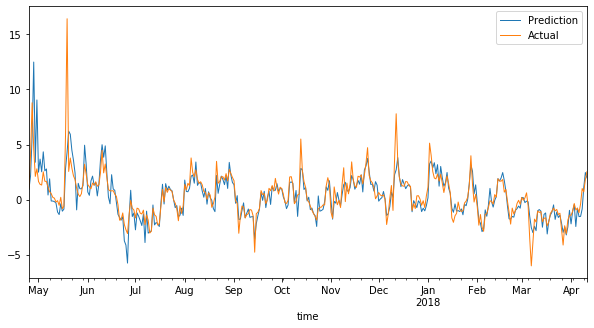

In [207]:
plt.figure(figsize=(10,5))

test_result[test_result['sym'] == sym]['pred'].plot(label='Prediction', lw=1)
test_result[test_result['sym'] == sym][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

<h2> Predicting on Train Set </h2>

In [ ]:
pred_Y = loop_predict(trainval_scaled, TRAIN_START, context_length, feat_columns, TARGET)

In [ ]:
train_result = train.copy()
train_result = pd.merge(trainval_result, pred_Y, how='left', left_on=['time', 'sym'], right_on=['time', 'sym'])

In [ ]:
pred_mean = trainval[TARGET+'_mean'].reset_index(drop=True)
pred_std = trainval[TARGET+'_std'].reset_index(drop=True)
train_result['pred'] = (trainval_result['pred'] * math.sqrt(scaler_train.var_[-1])) + scaler_train.mean_[-1]
# train_result['pred'] = (train_result['pred'] * pred_std) + pred_mean
train_result = trainval_result.set_index('time')

In [ ]:
sym = 'BTC'

In [ ]:
plt.figure(figsize=(10,5))

train_result[train_result['sym'] == sym]['pred'].plot(label='Prediction', lw=1)
train_result[train_result['sym'] == sym][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

In [305]:
predictor.delete_endpoint()

<h2> Trading </h2>

In [302]:
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

In [303]:
# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate_strategy(result, target, n=10, initial_value=10000):
    total_value = initial_value
    mean_roi = 0
    std_roi = 0
    
    value_history = []
    roi_history = []
    
    t = 1

    dates = list(set(result.index))
    dates.sort()
    
    df = result.copy()
    if target == 'price':
        df['predicted_roi'] = (df['pred']/df['price_lag_1']) - 1
    else:
        df['predicted_roi'] = df['pred']
    df.sort_values(by='predicted_roi', ascending=False, inplace=True)

    for date in dates:
        temp_df = df.query('time == @date & predicted_roi > 0')

        if not temp_df.empty:
            top_n = temp_df.nlargest(n, 'predicted_roi')
            selected_n = len(top_n)
            day_return = sum(top_n['roi'] * total_value / selected_n)
            day_roi = day_return/total_value
        else:
            day_return = 0
            day_roi = 0
        
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        sharpe_ratio = mean_roi/std_roi
        
        value_history.append(total_value)
        roi_history.append(day_roi)

        t += 1
        
    print('Cumulative Returns: {:.2e}%'.format(percent_returns))
    
    history = pd.concat([pd.DataFrame(dates), pd.DataFrame(value_history), pd.DataFrame(roi_history)], axis=1)
    history.columns = ['time', 'total_value', 'roi']
    history = history.set_index('time')
    return sharpe_ratio, percent_returns, history

In [304]:
result = evaluate_strategy(test_result, TARGET)

Cumulative Returns: 2.10e+06%
